In [30]:
from tqdm.notebook import tqdm
N = 100000000

for i in tqdm(range(N)):
    pass

  0%|          | 0/100000000 [00:00<?, ?it/s]

## Kommen Erstgeborene später zur Welt?

Oft hört man, dass erstgeborene Babies später zur Welt kommen als folgende Babies. Bei meinen eigenen Söhnen war das auch so. 
Aber gibt es da tatsächlichen einen Effekt? Und wenn ja, wie groß ist er?



Der folgende Code stammt aus dem Buch [Think Stats](https://greenteapress.com/thinkstats2). Er lädt einen Datensatz der [National Survey of Family Growth (NSFG)](http://cdc.gov/nchs/nsfg.htm) mit statistischen Informationen zu Schwangerschaften in den USA.

In [7]:
from __future__ import print_function
import numpy as np
import thinkstats2
import thinkplot

In [8]:
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb1 > 20, 'birthwgt_lb1'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb1.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz1.replace(na_vals, np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb1 + df.birthwgt_oz1 / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.phase = np.nan

In [9]:
def ReadFemPreg(dct_file='2006_2010_FemPregSetup.dct',
                dat_file='2006_2010_FemPreg.dat.gz'):
    """Reads the NSFG 2006-2010 pregnancy data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file, encoding='iso-8859-1')
    df = dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df

In [10]:
def MakeFrames():
    """Reads pregnancy data and partitions first babies and others.

    returns: DataFrames (all live births, first babies, others)
    """
    preg = ReadFemPreg()

    live = preg[preg.outcome == 1]
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    assert(len(live) == 14292)
    assert(len(firsts) == 6683)
    assert(len(others) == 7609)

    return live, firsts, others

Die folgende Zelle lädt die Datensätze zu Lebendgeburten insgesamt sowie Erstgeburten und Folgegeburten.

In [11]:
live, firsts, others = MakeFrames()

Das Feld `prglngth` enthält dabei die Länge der Schwangerschaft in Wochen.

In [12]:
live["prglngth"]

4        41
5        41
6        40
7        38
8        40
         ..
20486    42
20487    39
20489    41
20490    40
20491    41
Name: prglngth, Length: 14292, dtype: int64

## Aufgabe: Untersuchung der Daten

Untersuchen Sie die geladenen Daten:

- Wie ist die durchschnittliche Länge einer ersten bzw. folgenden Schwangerschaft?
- Wie hoch ist die Varianz der Schwangerschaftslänge?

(<Axes: >, <Axes: >)

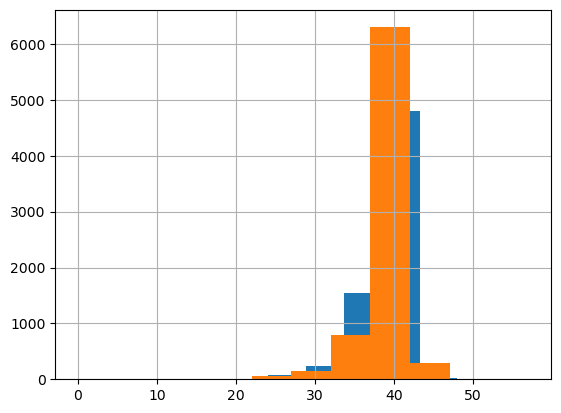

In [15]:
firsts["prglngth"].hist(), others["prglngth"].hist()

In [18]:
firsts["prglngth"].mean(), others["prglngth"].mean(), 7*(firsts["prglngth"].mean() - others["prglngth"].mean())

(38.587759988029326, 38.4230516493626, 1.1529583706670934)

## Kommen Erstgeborene später zur Welt? – Teil 2

Im ersten Teil haben wir gesehen, dass die Schwangerschaft bei Erstgebärenden im Schnitt knapp 1.2 Tage länger dauert als bei den übrigen Schwangerschaften.

Heute wollen wir untersuchen, ob dieser Effekt *statistisch signifikant* ist, d.h. ob er mit großer Wahrscheinlichkeit **nicht zufällig** ist.
Dazu folgen wir dem Ansatz:

- Wir haben insgesamt Daten zu 14292 Schwangerschaften mit Lebendgeburten, davon 6683 Erstgeburten. 
- Um zu untersuchen, ob der Unterschied signifikant ist, wählen wir zufällige Stichproben von 6683 Geburten aus und schauen uns an, wie der Durchschnitt der 
  Schwangerschaftsdauer in diesen Stichproben verteilt ist. Insbesondere bestimmen wir, in wie vielen Fällen der Unterschied größer ist als der beobachtete.
- Ist dies in mehr als **5%** der Stichproben der Fall ("p-Wert"), müssen wir davon ausgehen, dass wir eine zufällige Abweichung **nicht ausschließen** können.  

In [26]:
from tqdm.notebook import tqdm
N = 100000
cutoff = firsts["prglngth"].mean()

count = 0
for i in tqdm(range(N)):
    sample = live["prglngth"].sample(6683).mean()
    if sample > cutoff:
        count += 1
print(f"p-Wert: {count/N} {count}")

  0%|          | 0/100000 [00:00<?, ?it/s]

p-Wert: 6e-05 6
